# Hourly Time Series Forecasting using Facebook's Prophet
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [52]:
df = pd.read_excel('/Users/kao_oak/Desktop/Python/VS_Data/elder_bp.xlsx',index_col=[0], parse_dates=True) # We set the index column and know it has dates

df

,bp
time,
2022-03-06 09:33:00,115.0
2022-03-05 16:00:00,NaN
2022-03-05 09:36:00,108.0
2022-03-05 09:36:00,108.0
2022-03-04 16:00:00,NaN
...,...
2015-01-20 12:14:00,126.0
2015-01-20 12:14:00,126.0
2015-01-19 11:20:00,130.0


In [53]:
# remove NaN
df1 = df.dropna(axis=0, how='any')
df1

,bp
time,
2022-03-06 09:33:00,115.0
2022-03-05 09:36:00,108.0
2022-03-05 09:36:00,108.0
2022-03-04 09:56:00,146.0
2022-03-04 09:56:00,146.0
...,...
2015-01-20 12:14:00,126.0
2015-01-20 12:14:00,126.0
2015-01-19 11:20:00,130.0


<AxesSubplot:title={'center':'bp'}, xlabel='time'>

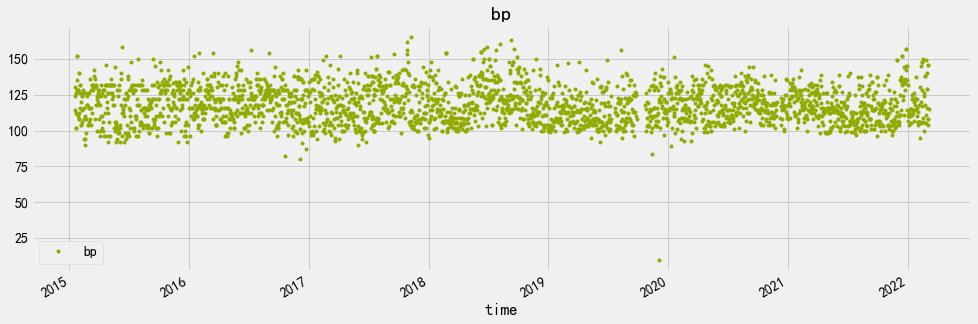

In [54]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
df1.plot(y='bp',style='.', figsize=(15,5), color=color_pal[2], title='bp')

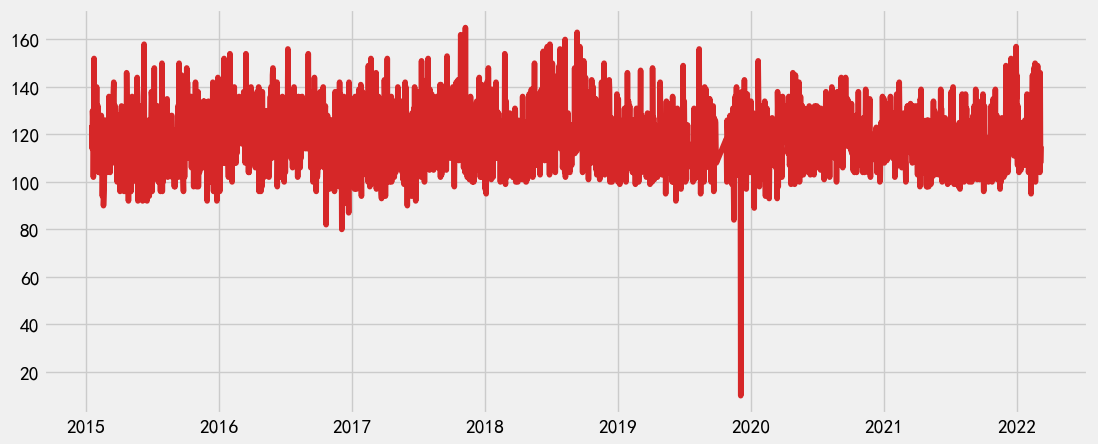

In [55]:
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(df1.index, df1.bp, color='tab:red')
plt.show()

# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

In [56]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df1, label='bp')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-56-e6bedd82c3a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-56-e6bedd82c3a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-56-e6bedd82c3a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

## Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

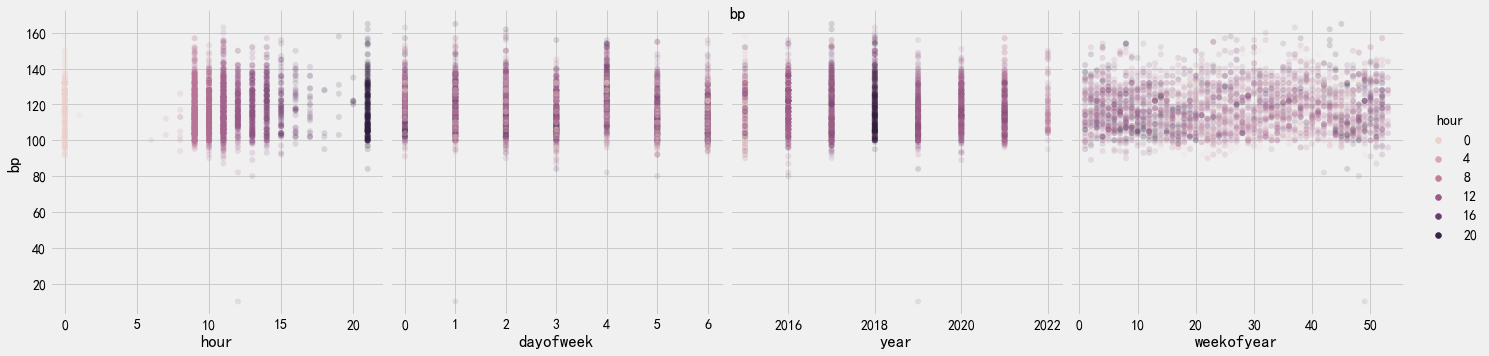

In [57]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='bp',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('bp')
plt.show()

# Model 2 : Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

## Train/Test Split
Cut off the data after 2020 to use as our validation set. We will train on earlier data.

In [58]:
split_date = '2020-06-01'
df1_train = df1.loc[df1.index <= split_date].copy()
df1_test = df1.loc[df1.index > split_date].copy()
print(df1_train.head()) #2103
print(df1_test.head()) #700

                        bp                date  hour  dayofweek  quarter  \
time                                                                       
2020-05-31 09:01:00  106.0 2020-05-31 09:01:00     9          6        2   
2020-05-30 12:23:00  111.0 2020-05-30 12:23:00    12          5        2   
2020-05-29 09:07:00  121.0 2020-05-29 09:07:00     9          4        2   
2020-05-28 13:50:00  105.0 2020-05-28 13:50:00    13          3        2   
2020-05-27 21:00:00  128.0 2020-05-27 21:00:00    21          2        2   

                     month  year  dayofyear  dayofmonth  weekofyear  
time                                                                 
2020-05-31 09:01:00      5  2020        152          31          22  
2020-05-30 12:23:00      5  2020        151          30          22  
2020-05-29 09:07:00      5  2020        150          29          22  
2020-05-28 13:50:00      5  2020        149          28          22  
2020-05-27 21:00:00      5  2020        148    

In [59]:
# Format data for prophet model using ds and y
df_ph_train = df1_train.reset_index().rename(columns={'time':'ds','bp':'y'})[['ds','y']]


df_ph_train

,ds,y
0,2020-05-31 09:01:00,106.0
1,2020-05-30 12:23:00,111.0
2,2020-05-29 09:07:00,121.0
3,2020-05-28 13:50:00,105.0
4,2020-05-27 21:00:00,128.0
...,...,...
2098,2015-01-20 12:14:00,126.0
2099,2015-01-20 12:14:00,126.0
2100,2015-01-19 11:20:00,130.0
2101,2015-01-18 15:03:00,114.0


In [60]:
# Setup and train model and fit
model = Prophet()
model.fit(df_ph_train)

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [61]:
# Predict on training set with model
df_ph_test = model.predict(df=df1_test.rename(columns={'date':'ds','bp':'y'})[['ds','y']])

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [62]:
df_ph_test.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-01 09:02:00,111.635400,103.684657,135.931977,111.635400,111.635400,8.259142,8.259142,8.259142,5.988804,...,2.584506,2.584506,2.584506,-0.314168,-0.314168,-0.314168,0.0,0.0,0.0,119.894542
1,2020-06-02 13:05:00,111.640828,103.685025,136.316068,111.640828,111.640828,8.120694,8.120694,8.120694,7.335327,...,1.126792,1.126792,1.126792,-0.341425,-0.341425,-0.341425,0.0,0.0,0.0,119.761522
2,2020-06-03 14:05:00,111.645666,104.591281,136.597865,111.645666,111.645666,8.385451,8.385451,8.385451,7.819936,...,0.914553,0.914553,0.914553,-0.349037,-0.349037,-0.349037,0.0,0.0,0.0,120.031117
3,2020-06-04 10:01:00,111.649524,96.311642,128.883735,111.649524,111.649524,0.801430,0.801430,0.801430,5.771672,...,-4.627877,-4.627877,-4.627877,-0.342365,-0.342365,-0.342365,0.0,0.0,0.0,112.450953
4,2020-06-05 09:06:00,111.653991,107.347277,140.450295,111.653991,111.653991,11.279748,11.279748,11.279748,6.056658,...,5.542501,5.542501,5.542501,-0.319412,-0.319412,-0.319412,0.0,0.0,0.0,122.933738


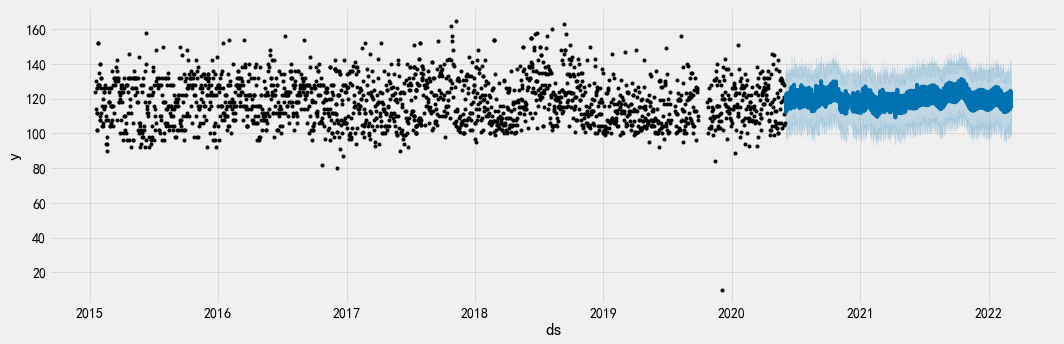

In [63]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(df_ph_test,ax=ax)
plt.show()

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py

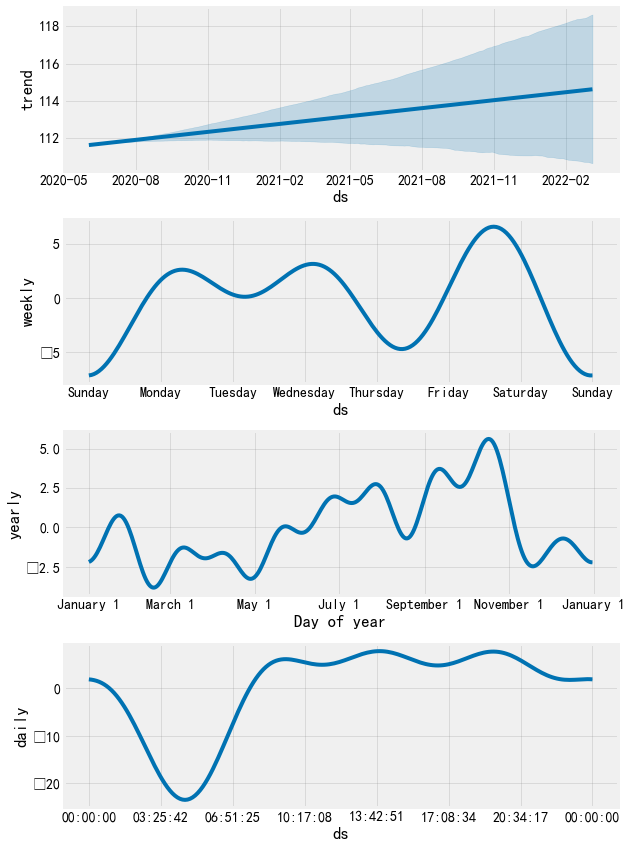

In [64]:
# Plot the components of the model
fig = model.plot_components(df_ph_test)

# Compare Forecast to Actuals

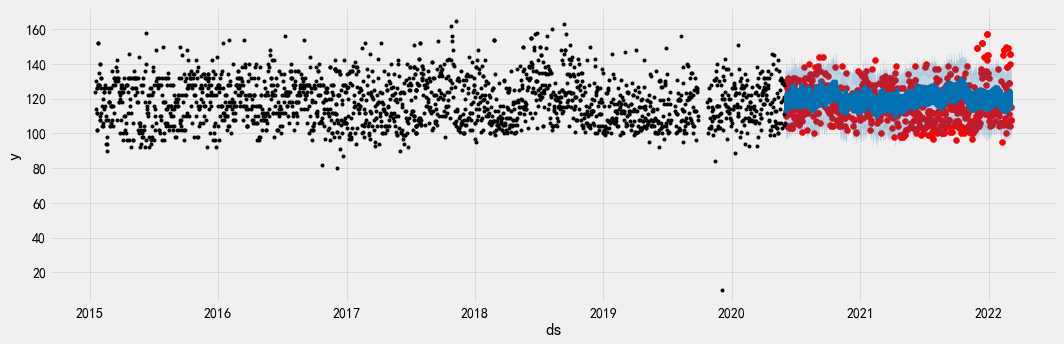

In [75]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df1_test.index, df1_test['bp'], color='r')

fig = model.plot(df_ph_test, ax=ax)

# Look at first month of predictions

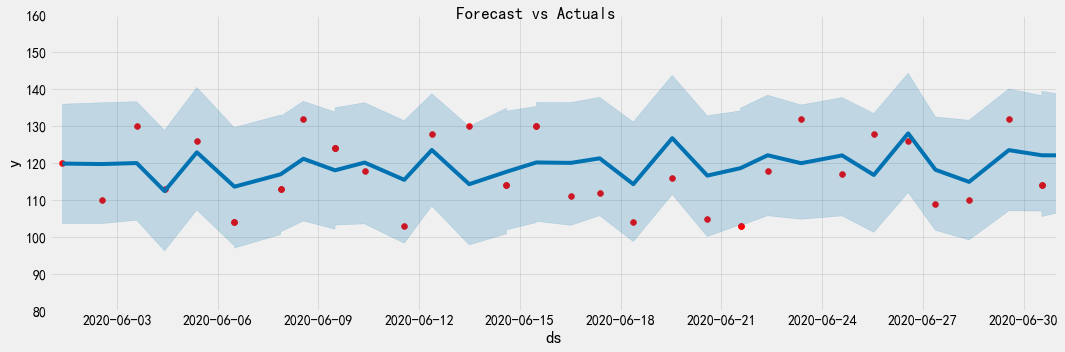

In [66]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df1_test.index, df1_test['bp'], color='r')
fig = model.plot(df_ph_test, ax=ax)
ax.set_xbound(lower='2020-06-01',upper='2020-07-01')
ax.set_ylim(80, 160)
plot = plt.suptitle(' Forecast vs Actuals')

# Single Week of Predictions

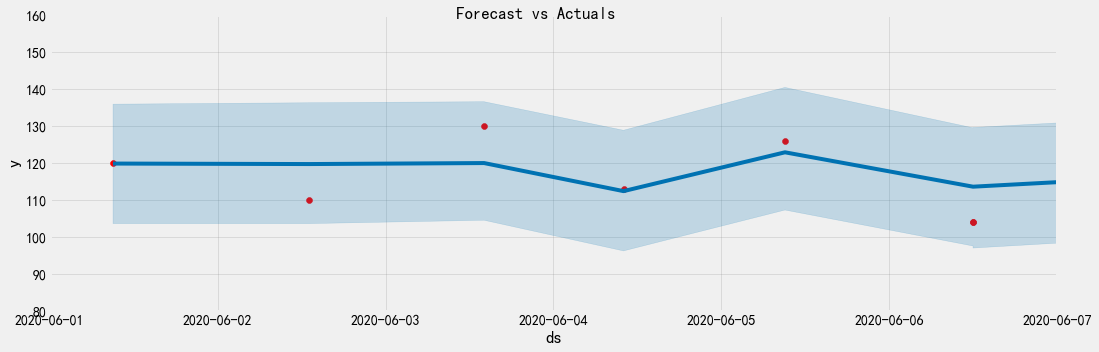

In [67]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df1_test.index, df1_test['bp'], color='r')
fig = model.plot(df_ph_test, ax=ax)
ax.set_xbound(lower='2020-06-01',upper='2020-06-07')
ax.set_ylim(80, 160)
plot = plt.suptitle(' Forecast vs Actuals')

# Error Metrics

Our RMSE error is 43761675  
Our MAE error is 5181.78  
Our MAPE error is 16.5%

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE):
[Check that out here](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-xgboost/)

In [68]:
mean_squared_error(y_true=df1_test['bp'],y_pred=df_ph_test['yhat'])

150.07185422755677

In [69]:
mean_absolute_error(y_true=df1_test['bp'],y_pred=df_ph_test['yhat'])

10.117545102350928

In [70]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df1_test['bp'],y_pred=df_ph_test['yhat'])

8.709801051278857

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

In [77]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=df1_train.index.min(),
                              end=df1_train.index.max())
test_holidays = cal.holidays(start=df1_test.index.min(),
                             end=df1_test.index.max())

In [78]:
# Create a dataframe with holiday, ds columns
df1['date'] = df1.index.date
df1['is_holiday'] = df1.date.isin([d.date() for d in cal.holidays()])

holiday_df = df1.loc[df1['is_holiday']] .reset_index() .rename(columns={'time':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df[['ds','holiday']]
holiday_df.head()

<ipython-input-78-0c623ba33985>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = df1.index.date
<ipython-input-78-0c623ba33985>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['is_holiday'] = df1.date.isin([d.date() for d in cal.holidays()])


,ds,holiday
0,2022-02-21 09:19:00,USFederalHoliday
1,2022-01-17 09:11:00,USFederalHoliday
2,2021-12-31 09:48:00,USFederalHoliday
3,2021-12-24 09:26:00,USFederalHoliday
4,2021-11-25 09:20:00,USFederalHoliday


In [79]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [80]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(df1_train.reset_index() \
                            .rename(columns={'time':'ds',
                                             'bp':'y'}))

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


## Predict With Holidays

In [81]:
df1_test

,bp,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
time,,,,,,,,,,
2022-03-06 09:33:00,115.0,2022-03-06 09:33:00,9,6,1,3,2022,65,6,9
2022-03-05 09:36:00,108.0,2022-03-05 09:36:00,9,5,1,3,2022,64,5,9
2022-03-05 09:36:00,108.0,2022-03-05 09:36:00,9,5,1,3,2022,64,5,9
2022-03-04 09:56:00,146.0,2022-03-04 09:56:00,9,4,1,3,2022,63,4,9
2022-03-04 09:56:00,146.0,2022-03-04 09:56:00,9,4,1,3,2022,63,4,9
...,...,...,...,...,...,...,...,...,...,...
2020-06-05 09:06:00,126.0,2020-06-05 09:06:00,9,4,2,6,2020,157,5,23
2020-06-04 10:01:00,113.0,2020-06-04 10:01:00,10,3,2,6,2020,156,4,23
2020-06-03 14:05:00,130.0,2020-06-03 14:05:00,14,2,2,6,2020,155,3,23


In [82]:
# Predict on training set with model
df_ph_test_with_hols = \
    model_with_holidays.predict(df=df1_test.reset_index() \
                                    .rename(columns={'time':'ds'}))

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


## Plot Holiday Effect

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py

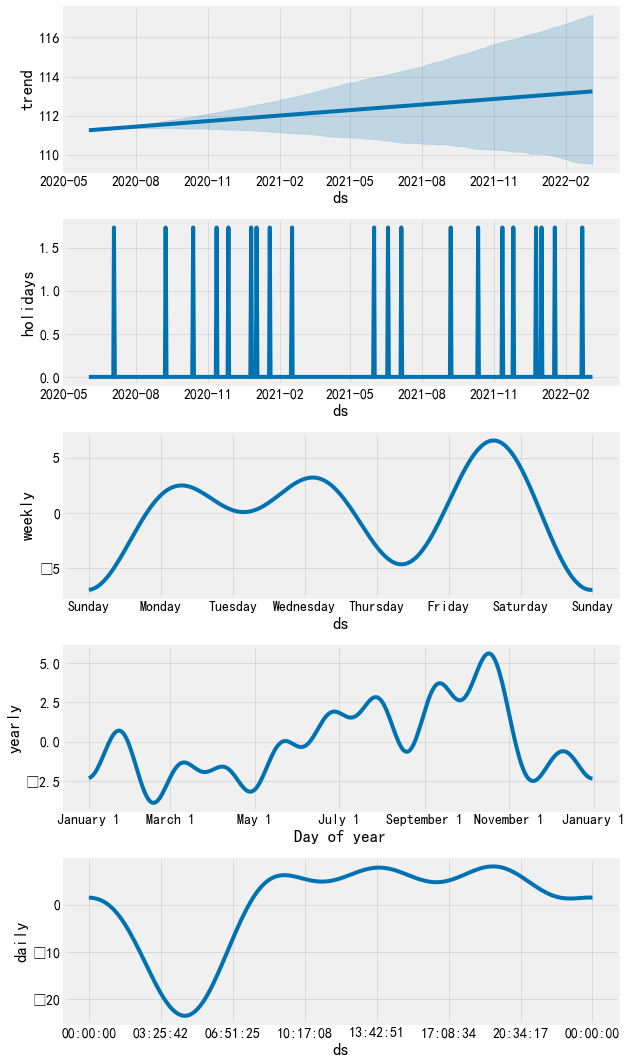

In [83]:
fig2 = model_with_holidays.plot_components(df_ph_test_with_hols)

# Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

In [84]:
mean_squared_error(y_true=df1_test['bp'],y_pred=df_ph_test_with_hols['yhat'])

147.4183026391723

In [85]:
mean_absolute_error(y_true=df1_test['bp'],
                   y_pred=df_ph_test_with_hols['yhat'])

9.960680879767965

In [86]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df1_test['bp'],
                   y_pred=df_ph_test_with_hols['yhat'])

8.528005031879225

# Compare Models Just for Holiday Dates
Lets plot Forecast model with and without holidays for 4th of July. It does look like the model with holidays is more accurate for this holiday.

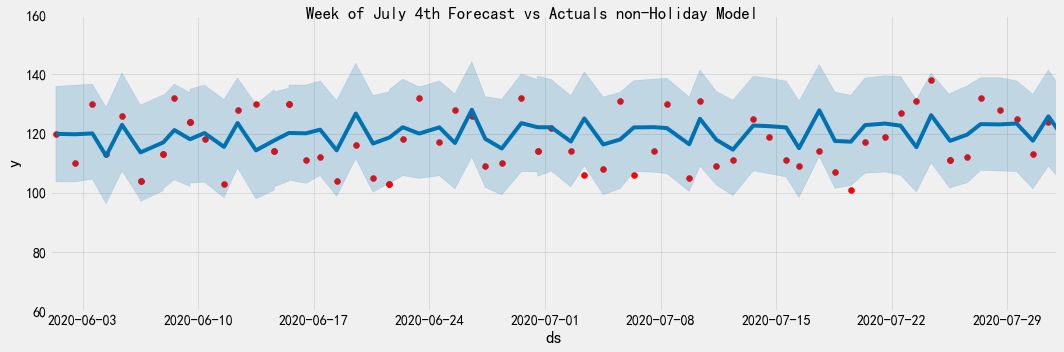

In [87]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df1_test.index, df1_test['bp'], color='r')
fig = model.plot(df_ph_test, ax=ax)
ax.set_xbound(lower='2020-06-01', upper='2020-08-01')
ax.set_ylim(60, 160)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals non-Holiday Model')

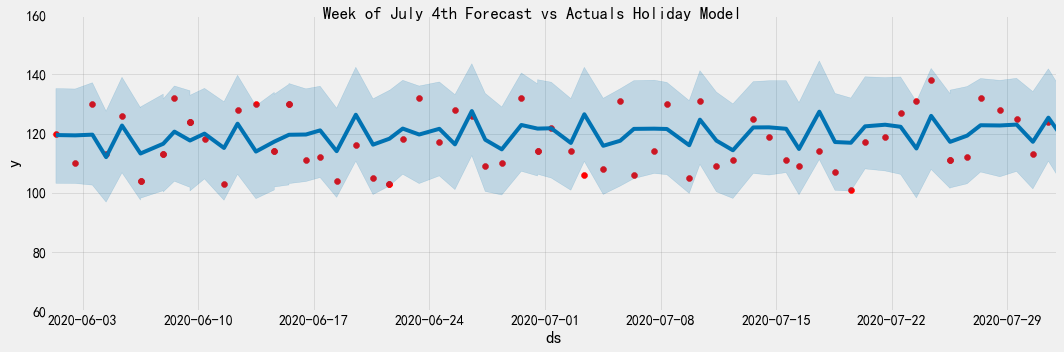

In [88]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df1_test.index, df1_test['bp'], color='r')
fig = model.plot(df_ph_test_with_hols, ax=ax)
ax.set_xbound(lower='2020-06-01', upper='2020-08-01')
ax.set_ylim(60, 160)
plot = plt.suptitle('Week of July 4th Forecast vs Actuals Holiday Model')

## Compare Error for just 4th of July
The error has gone down for this date.

In [89]:
jul4_test = df1_test.query('time >= 20200701 and time < 20200801')
jul4_pred = df_ph_test.query('ds >= 20200701 and ds < 20200801')
jul4_pred_holiday_model = df_ph_test_with_hols.query('ds >= 20200701 and ds < 20200801')

In [90]:
mean_absolute_error(y_true=jul4_test['bp'],y_pred=jul4_pred['yhat'])

9.934982304040151

In [91]:
mean_absolute_error(y_true=jul4_test['bp'],y_pred=jul4_pred_holiday_model['yhat'])

9.875405203407384

# Error of all Holidays
- Holiday error has gone up! This is unexpected.

In [92]:
holiday_list = holiday_df['ds'].tolist()

In [93]:
hols_test = df1_test.query('time in @holiday_list')
hols_pred = df_ph_test.query('ds in @holiday_list')
hols_pred_holiday_model = df_ph_test_with_hols.query('ds in @holiday_list')

In [94]:
mean_absolute_error(y_true=hols_test['bp'], y_pred=hols_pred['yhat'])

7.969505697090356

In [95]:
mean_absolute_error(y_true=hols_test['bp'],y_pred=hols_pred_holiday_model['yhat'])

8.260762214135253

# Identify Error by holiday
- We can see different holidays respond differently in this model. The model would perform better if we specifically identify holidays instead of lumping them all together as "USFederalHolidays"

In [101]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = df1_test.query('time in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = df_ph_test.query('ds in @holiday_list')
    hols_pred_holiday_model = df_ph_test_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['bp'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['bp'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: July 03, 2020:    
 MAE (non-holiday model): 19.1 
 MAE (Holiday Model): 20.5 
 Diff -1.4
Holiday: September 07, 2020:    
 MAE (non-holiday model): 3.9 
 MAE (Holiday Model): 2.7 
 Diff 1.2
Holiday: October 12, 2020:    
 MAE (non-holiday model): 17.3 
 MAE (Holiday Model): 18.3 
 Diff -1.0
Holiday: November 11, 2020:    
 MAE (non-holiday model): 4.3 
 MAE (Holiday Model): 5.4 
 Diff -1.0
Holiday: November 26, 2020:    
 MAE (non-holiday model): 4.5 
 MAE (Holiday Model): 5.6 
 Diff -1.1
Holiday: December 25, 2020:    
 MAE (non-holiday model): 10.9 
 MAE (Holiday Model): 11.7 
 Diff -0.8
Holiday: January 01, 2021:    
 MAE (non-holiday model): 4.1 
 MAE (Holiday Model): 4.9 
 Diff -0.8
Holiday: January 18, 2021:    
 MAE (non-holiday model): 8.3 
 MAE (Holiday Model): 7.3 
 Diff 0.9
Holiday: February 15, 2021:    
 MAE (non-holiday model): 1.5 
 MAE (Holiday Model): 0.8 
 Diff 0.7
Holiday: May 31, 2021:    
 MAE (non-holiday model): 4.1 
 MAE (Holiday Model): 4.7 
 Diff -0.

# Plot Error of Each Forecast
- We can see that both of our models generalize well, but struggle with peak demand days.
- Seems to be under forecasting many days.

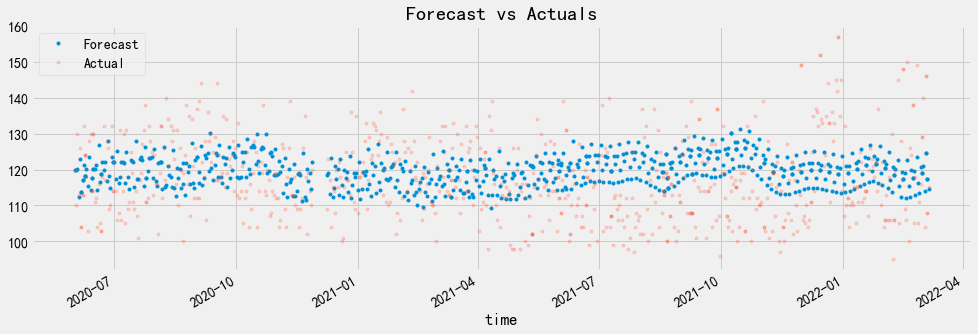

In [104]:
ax = df_ph_test.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                lw=0,
                                                style='.')
df1_test['bp'].plot(ax=ax,
                    style='.',
                    lw=0,
                    alpha=0.2)

plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals')
plt.show()

# Data Cleaning
- Data cleaning is a very important part of the forecasting process. If the input data contains garbage values, the forecast will use them when making predictions and could cause serious issues.
- We notice in the training data that we have some bad measurements where the values are much less. Could these be causing the under forecasting? Lets try removing this bad data.

This plot shows the bad data highlighted in red.

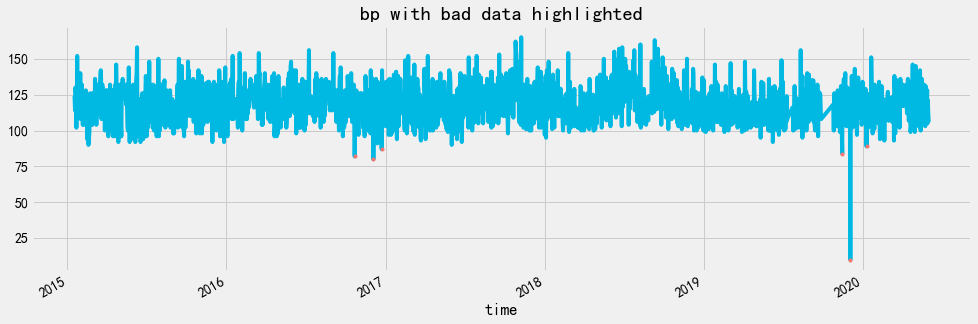

In [135]:
ax = df1_train.plot(style='-',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='bp with bad data highlighted',
                     y='bp'
                    )
df1_train.query('bp < 90').plot(style='.',
                                figsize=(15,5),
                                color=color_pal[0],
                                y='bp',
                                ax=ax)
ax.legend().set_visible(False)
plt.show()

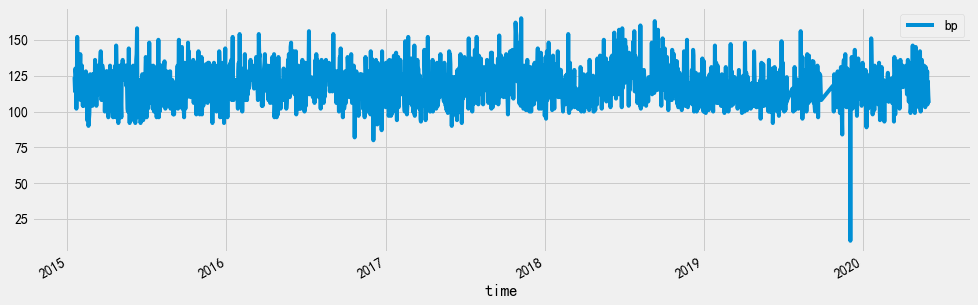

In [133]:
df1_train.plot(figsize=(15, 5),y='bp')
plt.show()

What caused this dip in energy demand? Hurricane Sandy!
Check out this wikipedia article: https://en.wikipedia.org/wiki/List_of_major_power_outages#2012


**On October 29–30, Hurricane Sandy brought high winds and coastal flooding to a large portion of the eastern United States, leaving an estimated 8 million customers without power. The storm, which came ashore near Atlantic City, New Jersey as a Category 1 hurricane, ultimately left scores of homes and businesses without power in New Jersey (2.7 million), New York (2.2 million), Pennsylvania (1.2 million), Connecticut (620,000), Massachusetts (400,000), Maryland (290,000), West Virginia (268,000), Ohio (250,000), and New Hampshire (210,000). Power outages were also reported in a number of other states, including Virginia, Maine, Rhode Island, Vermont, and the District of Columbia.**


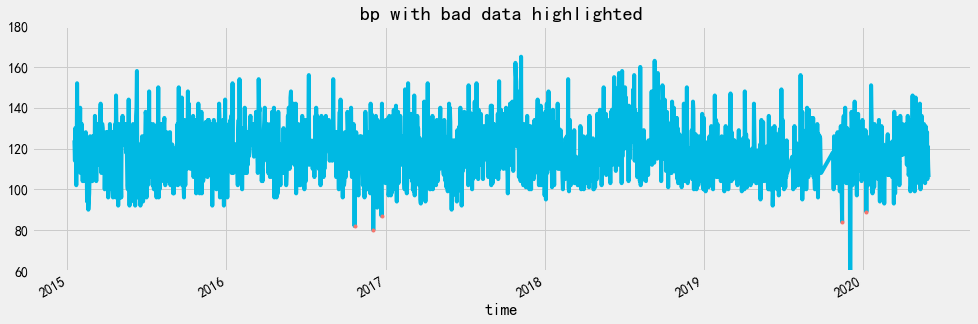

In [137]:
ax = df1_train.plot(style='-',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='bp with bad data highlighted',
                     y='bp',
                     ylim=(60, 180)
                    )
df1_train.query('bp < 90').plot(style='.',
                                figsize=(15,5),
                                color=color_pal[0],
                                y='bp',
                                ax=ax)
ax.legend().set_visible(False)
plt.show()

In [139]:
# Clean Data
df1_train['bp_clean'] = df1_train['bp']
df1_train.loc[df1_train['bp'] < 80, 'bp'] = np.nan

# Train model on clean data
model = Prophet()
model.fit(df1_train.reset_index() \
              .rename(columns={'time':'ds',
                               'bp_clean':'y'})
         )

# Predict on training set with clean model
df_test_fcst_clean = model.predict(df=df1_test.reset_index() \
                                   .rename(columns={'time':'ds'}))

/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/miniconda3/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


After cleaning we see a slight improvement in score compared to the first model. More data cleaning, along with holidays could yield even better results. Give it a try!

In [141]:
mse_clean = mean_squared_error(y_true=df1_test['bp'],
                               y_pred=df_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=df1_test['bp'],
                                y_pred=df_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=df1_test['bp'],
                                            y_pred=df_test_fcst_clean['yhat'])
print(f'Cleaned data model has MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

Cleaned data model has MSE 150.0719 - MAE 10.1175 - MAPE 8.7098


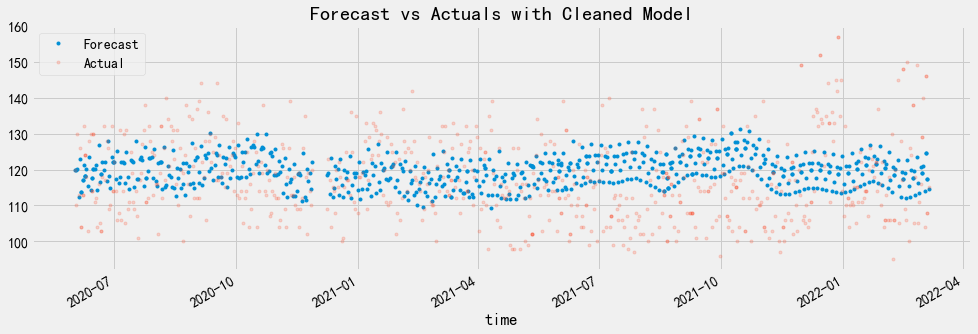

In [142]:
ax = df_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
df1_test['bp'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Forecast vs Actuals with Cleaned Model')
plt.show()

Thanks for reading! I hope you found this tutorial helpful.